In [1]:
import matplotlib.pyplot as plt
import numpy as np
import torch
from torch.utils.data import DataLoader, TensorDataset
from scipy import stats
import os
from datetime import datetime

from tqdm import tqdm

from src.models import *
from src.data_generation import *

### Create environment

In [17]:
n_traj = 20000       # no. of trajectories per env (20000)
n_in = 2            # Cartesian coordinates, no context
n_out = 100         # no. of spatial representations
timesteps = 250     # no. of timesteps
bs = 32             # batch size
epochs = 5         # no. of epochs
dt = 0.1            # timestep
speed_mean = 0.5    # mean speed
lr = 1e-4           # learning rate
scale = 0.2         # scale of gaussian

In [22]:
# Generate random env
env = generate_random_polygon_env(add_walls=True, add_holes=True)

# Generate random trajectory
r, v = generate_random_trajectories(env, n_traj=20, timesteps=timesteps, dt=dt, speed_mean=speed_mean)

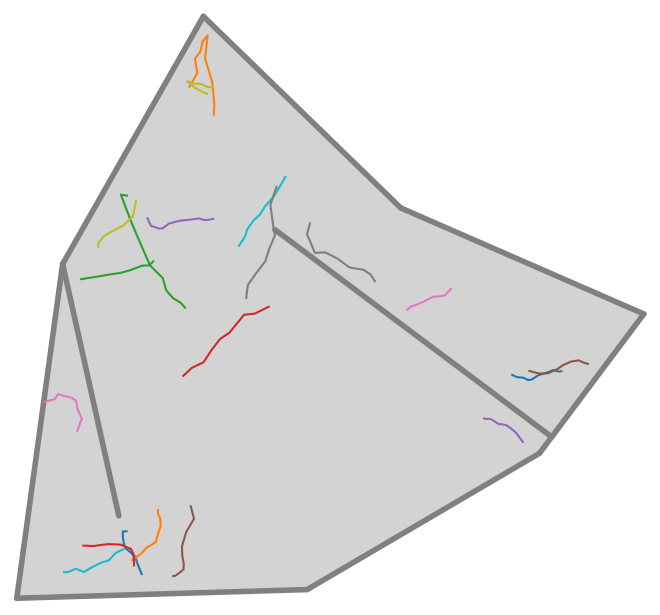

In [23]:
fig, ax = env.plot_environment()
ax.plot(r[:, :, 0].T, r[:, :, 1].T)
plt.show()

In [62]:
# Generate random trajectories
r, v = generate_random_trajectories(env, n_traj=n_traj, timesteps=timesteps, dt=dt, speed_mean=speed_mean)

# Create dataset
dataset = TensorDataset(r, v)

In [63]:
# Create id for saving based on current time
ident = datetime.now().strftime("%Y%m%d-%H%M%S") + '_short'
ident = datetime.now().strftime("%Y%m%d-%H%M%S") + '_long'

# Save dataset and environment
torch.save(env, os.path.join('/Users/frederikrogge/Data/bsr/datasets', f'env_{ident}.pt'))
torch.save(dataset, os.path.join('/Users/frederikrogge/Data/bsr/datasets', f'dataset_{ident}.pt'))

In [3]:
# Load dataset and environment
ident = "20230427-174900_long"
env = torch.load(os.path.join('/Users/frederikrogge/Data/bsr/datasets', f'env_{ident}.pt'))
dataset = torch.load(os.path.join('/Users/frederikrogge/Data/bsr/datasets', f'dataset_{ident}.pt'))

In [18]:
# Init model and optimizer
model = RecurrentSpaceNet(n_in, n_out, initial_state_size=32, corr_across_space=False, scale=scale)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

# Create dataloader
data = DataLoader(dataset, batch_size=bs, shuffle=True)

loss_history = []
for e in range(epochs):

    progress = tqdm(data)
    for i, (r_batch, v_batch) in enumerate(progress): # train loop

        loss = model.train_step(x=v_batch, y=r_batch[:, 1:], optimizer=optimizer)
        # loss = model.train_step(x=(v_batch, r_batch[:, 0]), y=r_batch[:, 1:], optimizer=optimizer)

        if i % 10 == 0:
            loss_history.append(loss)
            progress.set_description(f"loss: {loss:>7f}")

loss: 0.025780: 100%|██████████| 625/625 [00:18<00:00, 34.54it/s]


Text(0, 0.5, 'Train Loss')

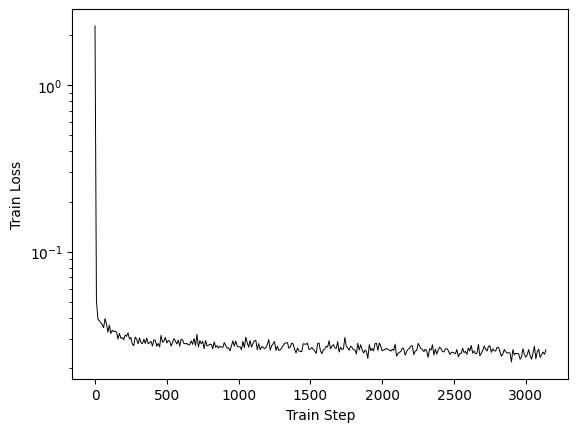

In [19]:
plt.semilogy(np.arange(len(loss_history))*10, loss_history, "-k", linewidth = 0.7)
plt.xlabel("Train Step")
plt.ylabel("Train Loss")

In [20]:
# Generate test data
r_test, v_test = generate_random_trajectories(env, n_traj=100, timesteps=timesteps, dt=dt, speed_mean=speed_mean)

# Get spatial representation
# p, _ = model.spatial_representation(v_test, model.initial_state(r_test[:, 0])[None])
p, _ = model.spatial_representation(v_test, model.initial_state(v_test.shape[0])[None])

p = p.detach().numpy()

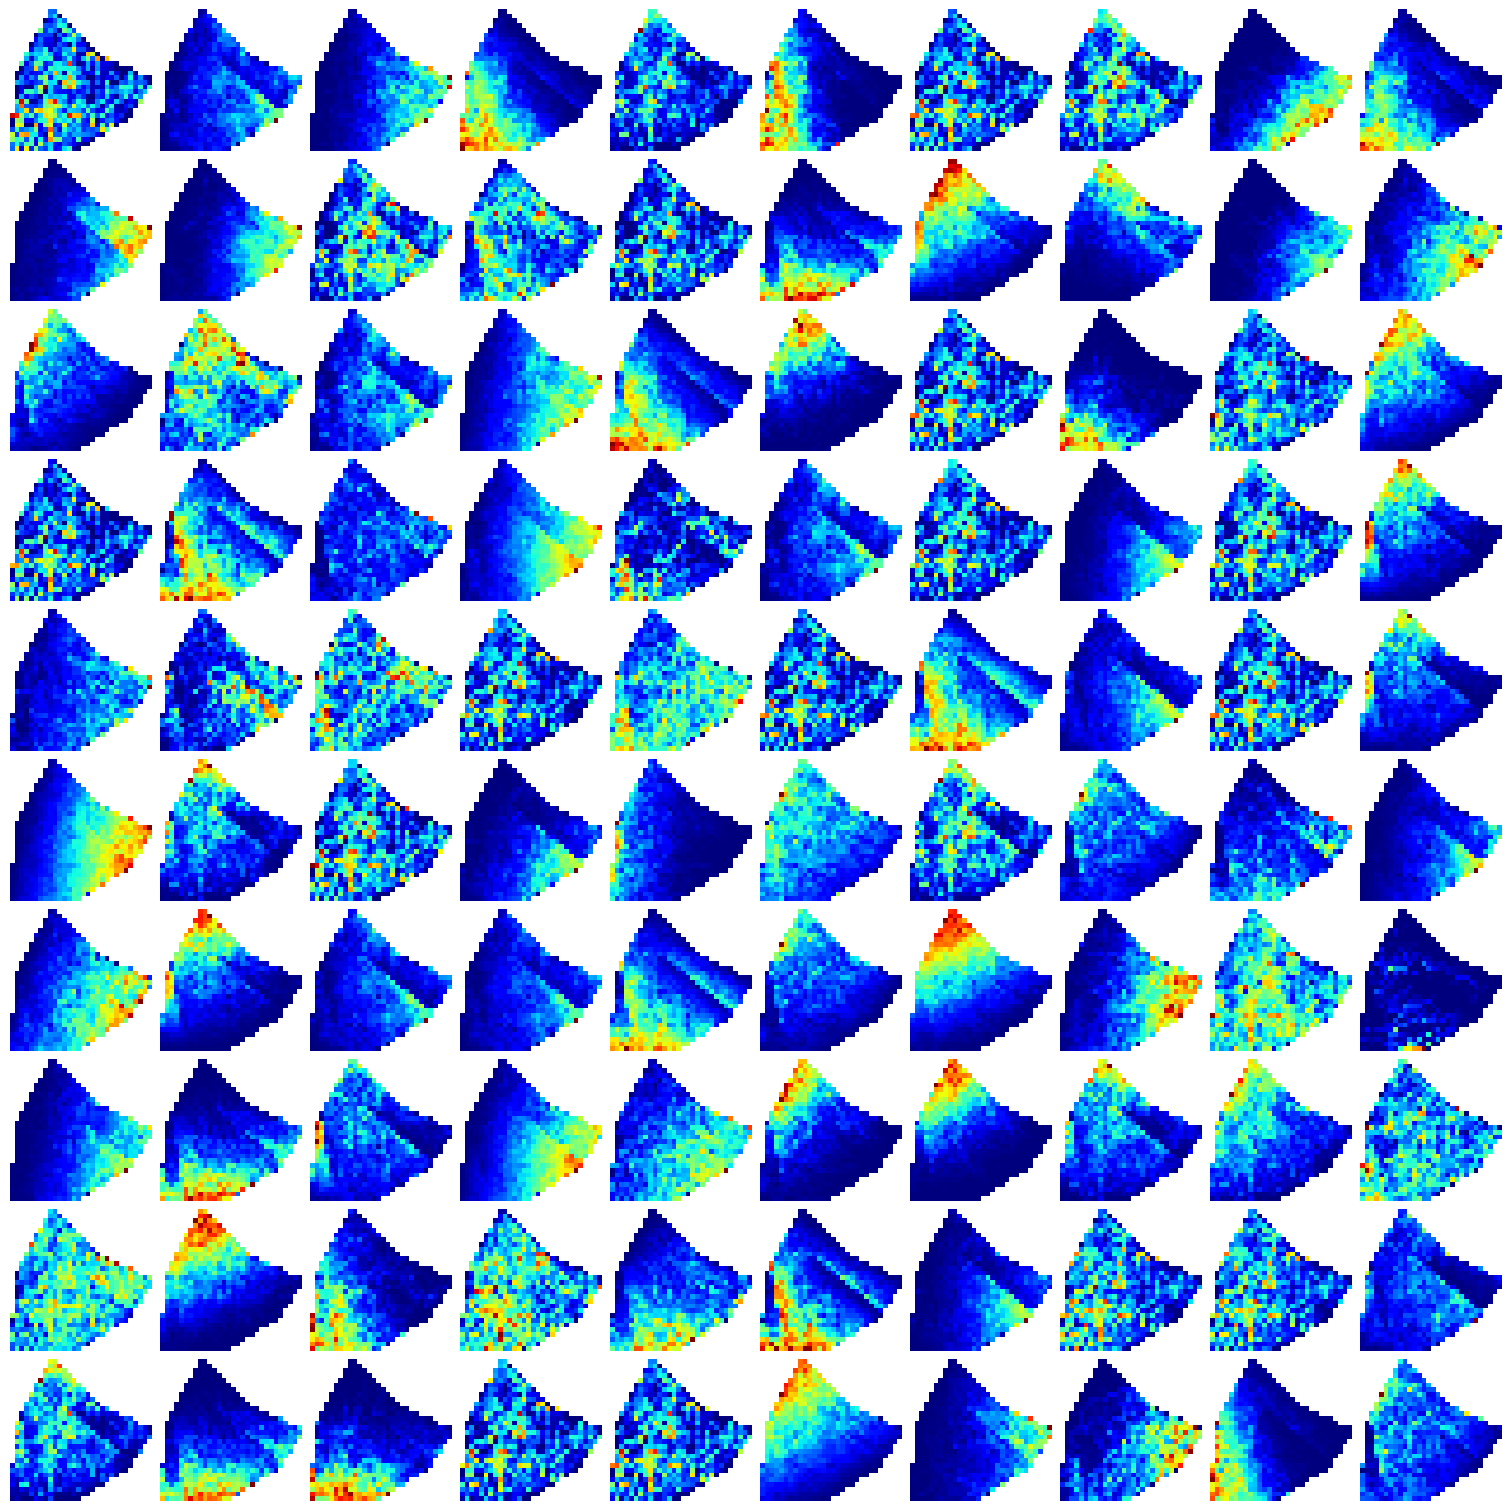

In [21]:
n_show = 10

fig, ax = plt.subplots(n_show, n_show, figsize=(15, 15), constrained_layout=True)

# Prepare stuff
r0 = r_test[:,1:].detach().numpy()
ps = p.reshape(-1, n_out)
rs = r0.reshape(-1, 2)

for i in range(n_show**2):
    hist, _, _, _ = stats.binned_statistic_2d(values=ps[:, i], x=rs[:,0], y=rs[:,1], bins=30)
    ax[i//n_show, i%n_show].imshow(hist.T, origin="lower", cmap = "jet")
    ax[i//n_show, i%n_show].axis("off")

Check the distribution of peaks

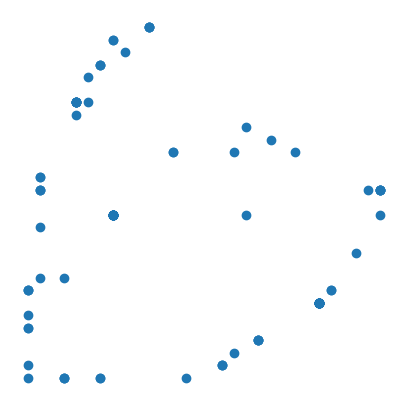

In [22]:
peaks = []
for i in range(ps.shape[-1]):
    hist, _, _, _ = stats.binned_statistic_2d(values=ps[:, i], x=rs[:,0], y=rs[:,1], bins=30)
    peaks.append(np.unravel_index(np.nanargmax(hist), hist.shape))
peaks = np.array(peaks)

fig, ax = plt.subplots(figsize=(5, 5))
ax.scatter(peaks[:, 0], peaks[:, 1])
ax.axis('off')
plt.show()

#### Long trajectories across space and time

In [13]:
n_traj = 1000       # no. of trajectories per env
n_in = 2            # Cartesian coordinates, no context
n_out = 500         # no. of spatial representations
timesteps = 250     # no. of timesteps
bs = 32             # batch size
epochs = 10         # no. of epochs
dt = 0.1            # timestep
speed_mean = 0.5    # mean speed
lr = 1e-4           # learning rate
scale = 0.4         # scale of gaussian

In [14]:
# Generate random trajectories
r, v = generate_random_trajectories(env, n_traj=n_traj, timesteps=timesteps, dt=dt, speed_mean=speed_mean)

# Create dataset
dataset = TensorDataset(r, v)

loss: 0.061587: 100%|██████████| 32/32 [00:26<00:00,  1.21it/s]


Text(0, 0.5, 'Train Loss')

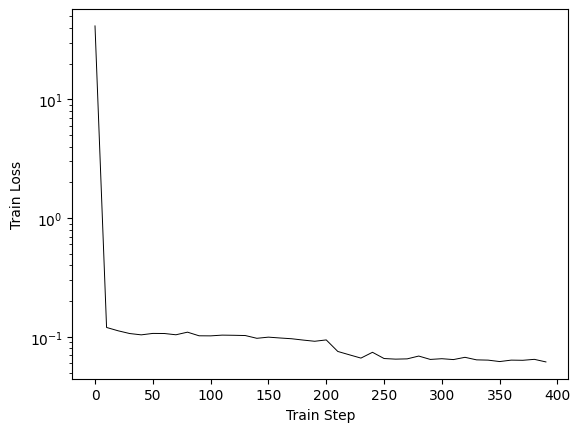

In [15]:
# Init model and optimizer
model = RecurrentSpaceNet(n_in, n_out, initial_state_size=2, corr_across_space=True)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

# Create dataloader
data = DataLoader(dataset, batch_size=bs, shuffle=True)

loss_history = []
for e in range(epochs):

    progress = tqdm(data)
    for i, (r_batch, v_batch) in enumerate(progress): # train loop

        # loss = model.train_step(x=v_batch, y=r_batch[:, 1:], optimizer=optimizer)
        loss = model.train_step(x=(v_batch, r_batch[:, 0]), y=r_batch[:, 1:], optimizer=optimizer)

        if i % 10 == 0:
            loss_history.append(loss)
            progress.set_description(f"loss: {loss:>7f}")

plt.semilogy(np.arange(len(loss_history))*10, loss_history, "-k", linewidth = 0.7)
plt.xlabel("Train Step")
plt.ylabel("Train Loss")

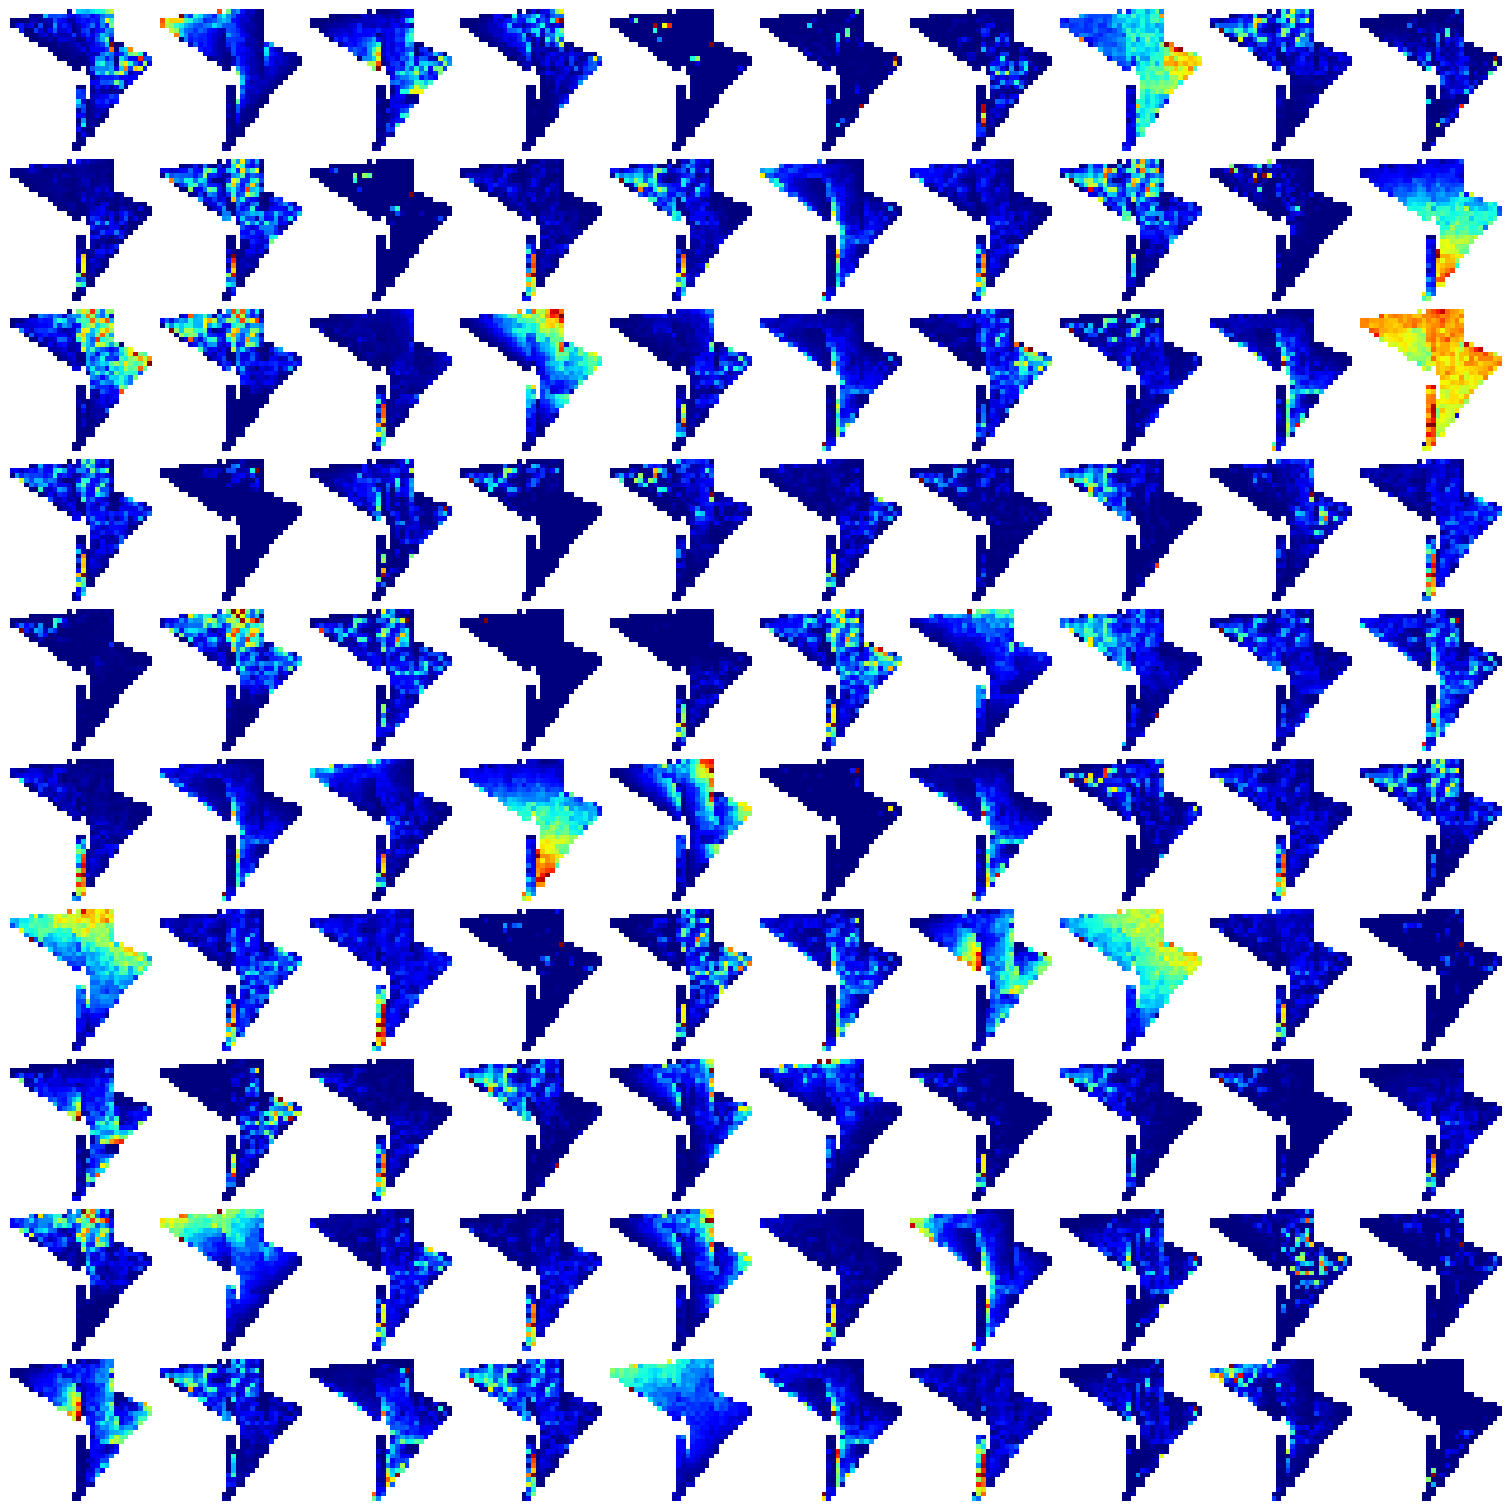

In [17]:
r_test, v_test = generate_random_trajectories(env, n_traj=100, timesteps=timesteps, dt=dt, speed_mean=speed_mean)
# p, _ = model.spatial_representation(v_test)

p, _ = model.spatial_representation(v_test, model.p0(r_test[:, 0])[None])

p = p.detach().numpy()

n_show = 10

fig, ax = plt.subplots(n_show, n_show, figsize=(15, 15), constrained_layout=True)
r0 = r_test[:, 1:].detach().numpy()

ps = p.reshape(-1, n_out)
rs = r0.reshape(-1, 2)

for i in range(n_show ** 2):
    hist, _, _, _ = stats.binned_statistic_2d(values=ps[:, i], x=rs[:, 0], y=rs[:, 1], bins=30)
    ax[i // n_show, i % n_show].imshow(hist.T, origin="lower", cmap="jet")
    ax[i // n_show, i % n_show].axis("off")